In this notebook, I use the Trash Detection dataset with YOLOv8 to build a model that helps a robot detect trash and differentiate between harmful and harmless objects in the sea this assists in cleaning the sea and keeping the environment clean.
The dataset is available at:
https://www.kaggle.com/datasets/shivamb/underwater-trash-detection

# load dataset  

In [1]:
import os

dataset_path = '/kaggle/input/underwater-trash-detection'

folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print("Folders in dataset:", folders)

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    print(f"{folder}: {len(images)} images")
    print("First 5 images:", images[:5])


Folders in dataset: ['val', 'test', 'train']
val: 820 images
First 5 images: ['obj1607_frame0000200.jpg', 'obj1314_frame0000306.jpg', 'obj1618_frame0000068.jpg', 'obj1302_frame0000088.jpg', 'obj1302_frame0000653.jpg']
test: 1144 images
First 5 images: ['bio0002_frame0000226.jpg', 'obj1108_frame0000037.jpg', 'bio0000_frame0000157.jpg', 'obj1663_frame0000575.jpg', 'obj1111_frame0000050.jpg']
train: 5720 images
First 5 images: ['obj0348_frame0000123.jpg', 'obj0313_frame0000036.jpg', 'obj0309_frame0000053.jpg', 'obj0305_frame0000050.jpg', 'bio0018_frame0000164.jpg']


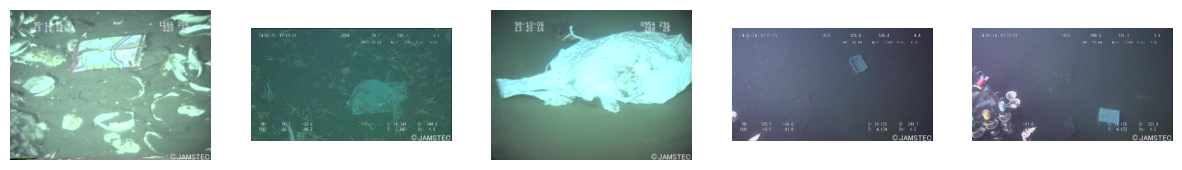

In [15]:
import cv2
import matplotlib.pyplot as plt

sample_folder = os.path.join(dataset_path, folders[0])
sample_images = [f for f in os.listdir(sample_folder) if f.endswith(('.jpg', '.png'))][:5]

plt.figure(figsize=(15,5))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(sample_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [16]:
import os
import xml.etree.ElementTree as ET
from collections import defaultdict

train_path = "/kaggle/input/underwater-trash-detection/train"

txt_counts = defaultdict(set)

for file in os.listdir(train_path):
    if file.endswith(".txt"):
        img = file.replace(".txt", "")
        with open(os.path.join(train_path, file)) as f:
            for line in f:
                cls = int(line.split()[0])
                txt_counts[cls].add(img)

txt_img_count = {k: len(v) for k, v in txt_counts.items()}

xml_counts = defaultdict(set)

for file in os.listdir(train_path):
    if file.endswith(".xml"):
        img = file.replace(".xml", "")
        tree = ET.parse(os.path.join(train_path, file))
        root = tree.getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text
            xml_counts[name].add(img)

xml_img_count = {k: len(v) for k, v in xml_counts.items()}

mapping = {}

for txt_cls, txt_count in txt_img_count.items():
    for xml_cls, xml_count in xml_img_count.items():
        if txt_count == xml_count:
            mapping[txt_cls] = xml_cls

print("Mapping TXT → NOMS DE CLASSES :\n")
for k in sorted(mapping):
    print(f"Classe {k} → {mapping[k]}")


Mapping TXT → NOMS DE CLASSES :

Classe 0 → plastic
Classe 1 → bio
Classe 2 → rov


# creer data yamal

In [2]:
%%writefile data.yaml
path: /kaggle/input/underwater-trash-detection
train: train
val: val
test: test

nc: 3
names:
  0: plastic
  1: bio
  2: rov


Writing data.yaml


In [3]:
!pip install -q ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00a 0:00:01


#  Build and train the model YOLOv8

In [4]:
from ultralytics import YOLO
import torch

torch.cuda.empty_cache()

model = YOLO("yolov8s.pt")

model.train(
    data="data.yaml",
    epochs=30,
    imgsz=640,
    batch=4,        

    cls=2.0,

    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.2,

    fliplr=0.5
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.0, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fafcc614fe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Evaluation with test

In [12]:
test_metrics = model.val(
    data="data.yaml",
    split="test"
)

print("=== MÉTRIQUES SUR TEST ===")
print(test_metrics)


Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3.9±0.7 MB/s, size: 21.9 KB)
val: Scanning /kaggle/input/underwater-trash-detection/test... 1144 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1144/1144 227.8it/s 5.0s0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/underwater-trash-detection is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 72/72 10.0it/s 7.2s0.1s
                   all       1144       1668       0.96      0.942      0.981      0.797
               plastic        858        937      0.993      0.975      0.994      0.757
                   bio        322        396      0.959       0.94      0.984      0.808
                   rov        258        335      0.928       0.91      0.966      0.825
Sp

# validation

In [7]:
val_metrics = model.val(
    data="data.yaml",
    split="val"
)

precision = val_metrics.box.mp
recall = val_metrics.box.mr
map50 = val_metrics.box.map50
map5095 = val_metrics.box.map

accuracy_det = (precision + recall) / 2

print("=== MÉTRIQUES VALIDATION FINALE ===")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"mAP50     : {map50:.4f}")


Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 53.6±28.6 MB/s, size: 25.7 KB)
val: Scanning /kaggle/input/underwater-trash-detection/val... 820 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 820/820 1.3Kit/s 0.7s0.1ss
WARNING ⚠️ val: Cache directory /kaggle/input/underwater-trash-detection is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 6.3it/s 8.2s0.2s
                   all        820       1064      0.534      0.465      0.452      0.298
               plastic        819        853      0.903      0.655      0.825       0.57
                   bio         54         70      0.223      0.257      0.144     0.0842
                   rov        141        141      0.475      0.482      0.389      0.241
Speed: 0.7ms preprocess, 6.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved t